In [1]:
import torch
import matplotlib.pyplot as plt

import math
from torch.nn.functional import conv1d
from torch.nn.functional import pad
from torch.autograd import grad

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [4, 2]

In [2]:
# define signal and kernel
L = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5
u = torch.sin(freq * x)

M = 30
x = torch.linspace(-2, 2, M) 
h = torch.exp(- x.pow(2))

# toeplitz utilities
def centered_toeplitz(h, L, M):
    T = torch.zeros(L - M + 1, L)

    T[0, :M] = h
    for i in range(1, L - M + 1): T[i] = torch.roll(T[i-1], 1)
    return T

def full_toeplitz(h, L, M):
    T = torch.zeros(L + M - 1, L)
    for i in range(M): T[i, :i+1] = h[-i-1:]
    for i in range(M, L): T[i] = torch.roll(T[i-1], 1)
    for i in range(L, L + M - 1):
        T[i, -M+i-L+1:] = h[:-i-1+L]
    return T
    
def circular_toeplitz(h, L, M):
    T = torch.zeros(L, L)

    T[0, :1] = h[0]
    T[0, -M+1:] = h[1:]
    for i in range(1, L): T[i] = torch.roll(T[i-1], 1)
    return T

def fft_conv(u, h):
    L, M = u.shape[0], h.shape[0]
    T = circular_toeplitz(h, L + M - 1, M)
    u_pad = pad(u, (0, M - 1))
    return T @ u_pad


## Causality

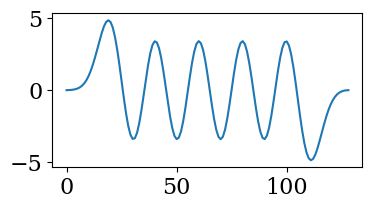

In [3]:
u.requires_grad = True
y = fft_conv(u, h)
plt.plot(y.detach())

Is this a causal convolution? In other words, does $y[k]$ depend only on values $u[n]$ with $n \leq k$? One way to check
is by computing the gradient $\frac{d y[k]}{d u[n]}$

In [4]:
dydu = torch.zeros(L, L)
for n in range(L):
    dydu[n] = grad(y[n], u, retain_graph=True)[0]

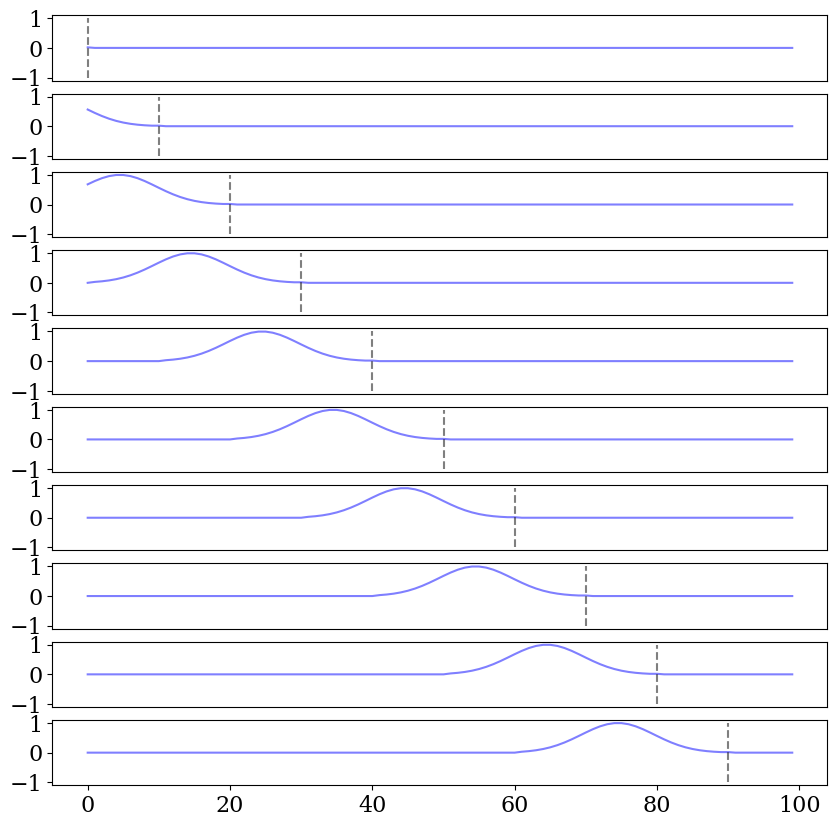

In [5]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))
for k in range(10): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k, -1, 1, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

There is no information flowing "forward" in the future i.e., from index $k$ to $n > k$, since the gradients are zero. Notice how 
the "memory" is also limited: after $M - 1$ steps, the gradients are zero. Is this a coincidence?

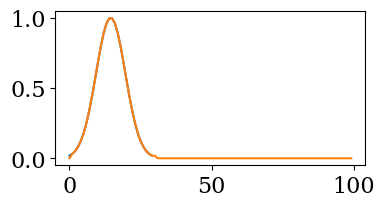

In [6]:
plt.plot(h)
plt.plot(dydu[30].detach())

As discussed in the notes, the gradient is exactly `h`. After all, the convolution is a linear operation.

Recall the original "centered" convolution. In that case, the operation is not causal, hence care must be taken if the causality property is desired:


In [7]:
y_centered = centered_toeplitz(h, L, M) @ u

In [8]:
dydu = torch.zeros(L, L)
for n in range(L - M + 1):
    dydu[n] = grad(y_centered[n], u, retain_graph=True)[0]

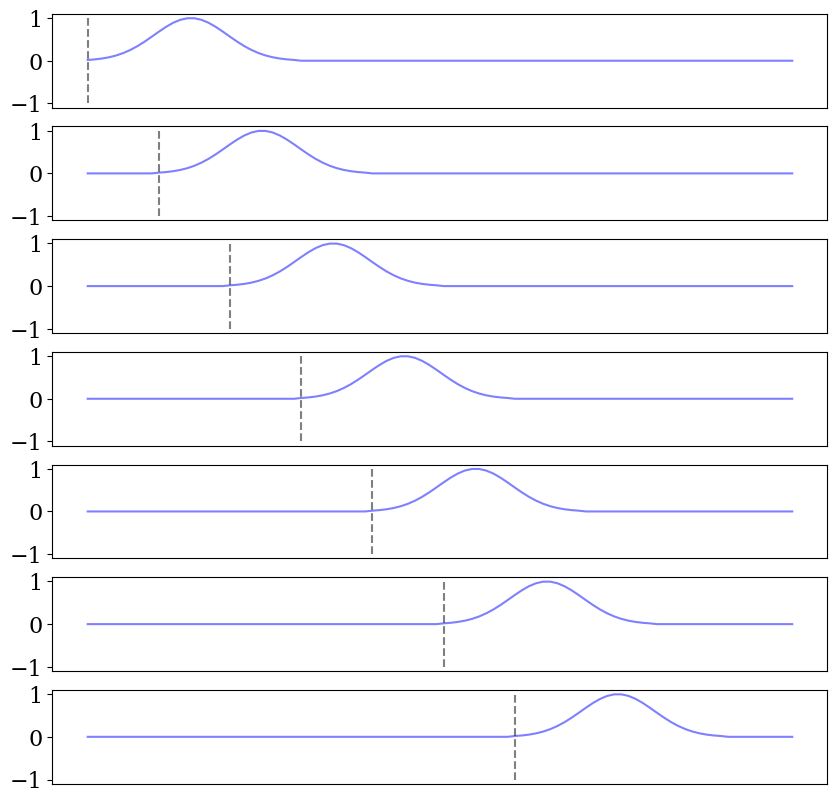

In [9]:
fig, axs = plt.subplots(7, 1, figsize=(10, 10))
for k in range(7): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k, -1, 1, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

This result should be intuitive by this point (if it is not, no worries, step through the first notebook!): centered convolutions start with the kernel overlapping `u`, with the first output `y[0]` computed as a linear combination of `u[0]`, ...,  `u[M-1]`. 

Causality is easily reintroduced by appropriate padding: we have previously shown how to pad `u` to recover full convolutions from centered convolutions.

### The Frequency Domain

Let us look at a different basic convolution kernel.

In [10]:
h = torch.exp(- torch.arange(L))

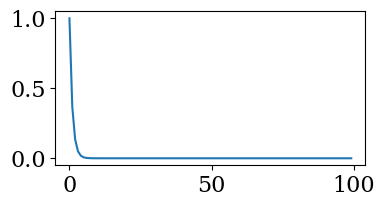

In [11]:
plt.plot(h)

In [12]:
H = torch.fft.fft(h)

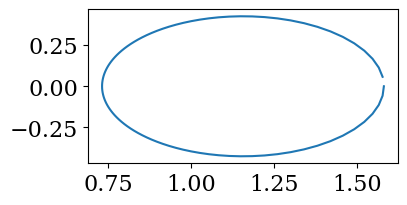

In [13]:
plt.plot(H.real, H.imag)

There is some kind of symmetry...

In [14]:
def hilbert(u):
    L = u.shape[0]
    U = torch.fft.fft(u)
    L_mid = L - L//2 - 1
    U[L//2+1:] = torch.zeros(L_mid)
    U[1:L//2] = 2 * U[1:L//2]
    v = torch.fft.ifft(U)
    return 1j* (v - u)

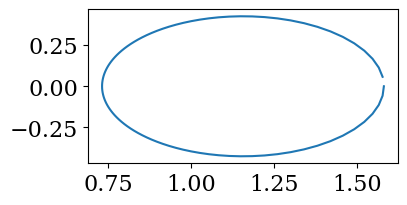

In [16]:
plt.plot(H.real, hilbert(H.real).real)

We have recovered the imaginary part of the Fourier transform of `h` directly from its real part via a Hilbert transform. This is directly an application of the Kramers-Kronig relations discussed in the text. Note that this
is valid only in the case of causal convolutions!

A formal treatment requires results from complex analysis. Our showcase here eschews a formal exposition in favor of intuition and visualization.